### Test notebook for Twitter Sentiment analysis 


((https://www.youtube.com/watch?v=4YGkfAd2iXM))

In [4]:
import os
import shutil

###### Kaggle dataset config

In [ ]:
# Configuration only if using Kaggle datasets
kaggle_dir = os.path.expanduser("~/.kaggle")
kaggle_json_path = 'C:/Users/dugara/Documents/GitHub-POC/SentimentAnalysis/kaggle.json'  # Adjust this if the file is elsewhere

# Ensure the directory exists, and copy the file
os.makedirs(kaggle_dir, exist_ok=True)  # Create .kaggle dir if it doesn't exist
shutil.copy(kaggle_json_path, kaggle_dir)  # Copy kaggle.json to the .kaggle directory


'C:\\Users\\dugara/.kaggle\\kaggle.json'

##### Extracting the dataset with twitter comments

In [31]:
import zipfile
import os

# Define paths
zip_file_path = '../Datasets/Zip/Twitter.zip'  # Adjust to your path
extract_dir = '../Datasets/Data/'  # Adjust to your desired directory

# Extract the dataset if it's in a zip file
if zip_file_path.endswith('.zip'):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Dataset extracted to {extract_dir}")
else:
    print("Dataset is already extracted.")

Dataset extracted to ../Datasets/Data/


##### Load the Dataset

In [32]:
import pandas as pd

# Path to the Sentiment140 dataset (adjust based on the extracted folder)
dataset_path = os.path.join(extract_dir, 'training.1600000.processed.noemoticon.csv')  # Change the file name if needed

# Load the dataset into a pandas DataFrame
df = pd.read_csv(dataset_path, encoding='latin1', header=None)

# Columns of the dataset
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']

# Check the first few rows
print(df.head())


   target          id                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  


##### Cleaning the Text Data

In [33]:
import re

# Basic text cleaning function
def clean_text(text):
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions (@user)
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = text.lower()  # Convert to lowercase
    return text

# Apply the cleaning function to the text column
df['cleaned_text'] = df['text'].apply(clean_text)

# Show cleaned data
print(df[['text', 'cleaned_text']].head())


                                                text  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1  is upset that he can't update his Facebook by ...   
2  @Kenichan I dived many times for the ball. Man...   
3    my whole body feels itchy and like its on fire    
4  @nationwideclass no, it's not behaving at all....   

                                        cleaned_text  
0     a thats a bummer  you shoulda got david car...  
1  is upset that he cant update his facebook by t...  
2   i dived many times for the ball managed to sa...  
3    my whole body feels itchy and like its on fire   
4   no its not behaving at all im mad why am i he...  


##### Sentiment Analysis using VADER

In [46]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Apply VADER sentiment analysis
df['vader_sentiment'] = df['cleaned_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Convert compound score into sentiment labels (1 = positive, 0 = negative)
df['vader_sentiment_label'] = df['vader_sentiment'].apply(lambda x: 1 if x >= 0 else 0)

# Check results
print(df[['cleaned_text', 'vader_sentiment', 'vader_sentiment_label']].head())


                                        cleaned_text  vader_sentiment  \
0     a thats a bummer  you shoulda got david car...          -0.3818   
1  is upset that he cant update his facebook by t...          -0.7269   
2   i dived many times for the ball managed to sa...           0.4939   
3    my whole body feels itchy and like its on fire           -0.2500   
4   no its not behaving at all im mad why am i he...          -0.6597   

   vader_sentiment_label  
0                      0  
1                      0  
2                      1  
3                      0  
4                      0  


##### Sentiment Analysis using RoBERTa

In [45]:
import torch
import os
import certifi
import ssl
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

# SSL Configuration
def configure_ssl():
    """Configure SSL certificates and environment variables"""
    os.environ['REQUESTS_CA_BUNDLE'] = certifi.where()
    os.environ['SSL_CERT_FILE'] = certifi.where()
    ssl._create_default_https_context = ssl._create_unverified_context

def setup_roberta(offline_mode=False):
    """Initialize RoBERTa model and tokenizer with SSL handling"""
    configure_ssl()
    
    try:
        # First attempt: Standard loading with SSL fixes
        tokenizer = AutoTokenizer.from_pretrained(
            'roberta-base',
            use_auth_token=True,  # If you have a Hugging Face token
            local_files_only=offline_mode
        )
        model = AutoModelForSequenceClassification.from_pretrained(
            'roberta-base',
            use_auth_token=True,
            local_files_only=offline_mode
        )
    except Exception as e:
        print(f"First attempt failed: {str(e)}")
        print("Trying alternative loading method...")
        
        # Second attempt: Using cache directory
        cache_dir = os.path.expanduser("~/.cache/huggingface/transformers")
        tokenizer = AutoTokenizer.from_pretrained(
            'roberta-base',
            cache_dir=cache_dir,
            local_files_only=True
        )
        model = AutoModelForSequenceClassification.from_pretrained(
            'roberta-base',
            cache_dir=cache_dir,
            local_files_only=True
        )
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    return tokenizer, model, device

def get_roberta_sentiment(text, tokenizer, model, device):
    """Get sentiment prediction for a single text"""
    try:
        inputs = tokenizer(
            text,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        ).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        probabilities = torch.softmax(outputs.logits, dim=-1)
        prediction = torch.argmax(outputs.logits, dim=-1).item()
        confidence = probabilities.max().item()
        
        return prediction, confidence
    except Exception as e:
        print(f"Error processing text: {str(e)}")
        return 0, 0.0  # Default values in case of error

def analyze_sentiment(df, offline_mode=False):
    """Process the DataFrame with RoBERTa sentiment analysis"""
    # Setup with SSL handling
    tokenizer, model, device = setup_roberta(offline_mode)
    model.eval()
    
    results = []
    
    # Process in smaller batches
    batch_size = 16  # Reduced batch size for stability
    
    for i in tqdm(range(0, len(df), batch_size)):
        batch = df['cleaned_text'].iloc[i:i+batch_size]
        batch_results = []
        
        for text in batch:
            if isinstance(text, str):
                pred, conf = get_roberta_sentiment(text, tokenizer, model, device)
                batch_results.append((pred, conf))
            else:
                batch_results.append((0, 0.0))  # Default for invalid text
                
        results.extend(batch_results)
    
    # Unpack results
    predictions, confidences = zip(*results)
    
    # Add to DataFrame
    df['roberta_sentiment'] = predictions
    df['roberta_confidence'] = confidences
    
    return df

# Example usage
if __name__ == "__main__":
    import pandas as pd
    
    try:
        # Try online mode first
        df = analyze_sentiment(df)
    except Exception as e:
        print(f"Online mode failed: {str(e)}")
        print("Trying offline mode...")
        # Fall back to offline mode
        df = analyze_sentiment(df, offline_mode=True)
    
    print(df[['cleaned_text', 'roberta_sentiment', 'roberta_confidence']].head())

c:\Users\dugara\Documents\GitHub-POC\SentimentAnalysis\venv\Lib\site-packages\transformers\models\auto\tokenization_auto.py:823: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
c:\Users\dugara\Documents\GitHub-POC\SentimentAnalysis\venv\Lib\site-packages\transformers\models\auto\auto_factory.py:471: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


First attempt failed: (MaxRetryError("HTTPSConnectionPool(host='cdn-lfs.hf.co', port=443): Max retries exceeded with url: /roberta-base/5bde1d28afb363d0103324efeb5afc8b2b397fe5e04beabb9b1ef355255ade81?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1739273979&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczOTI3Mzk3OX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yb2JlcnRhLWJhc2UvNWJkZTFkMjhhZmIzNjNkMDEwMzMyNGVmZWI1YWZjOGIyYjM5N2ZlNWUwNGJlYWJiOWIxZWYzNTUyNTVhZGU4MT9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSoifV19&Signature=KdqkKoVYHPHQ4EH3JUqlRZuFrg15k8s8su3NRAwqq3sl4totMMz-Gl7~-OZKDaT2nLfDzgjJ4RWY2wHD3lHhnIHuXOk9caaDi3KVntWdxGhLqNQRa5z0mSrNMk3eHk06GHrNH4bsw7YvljDMB9xYda~YZ33N5uMHuXO25oNS1YSNUMR6cJJxeOSKt2QaOQoaX~tBeeReMYNOgvUAT~eNL~ZCCHjaEintFaHzBXExQ9pUjx1YxEiw9TrfXsy2PYdU1yXRRWFjSTq5VRmMY76g5e84b9QMk7mA6AdvNTJqsQxzGlsmVAdvAXkNDVMypym6wZkv0WDstxgquhUz9SjA1A__&Key-

OSError: We couldn't connect to 'https://huggingface.co' to load this file, couldn't find it in the cached files and it looks like roberta-base is not the path to a directory containing a file named config.json.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

##### Using DistilBERT for Sentiment Analysis

In [49]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch

# Load the tokenizer and model for DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',)
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

# Ensure you're using the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to predict sentiment using DistilBERT
def get_distilbert_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=-1).item()  # 0 = negative, 1 = positive
    return prediction

# Apply DistilBERT sentiment analysis
df['distilbert_sentiment'] = df['cleaned_text'].apply(get_distilbert_sentiment)

# Check results
print(df[['cleaned_text', 'distilbert_sentiment']].head())


SSLError: (MaxRetryError("HTTPSConnectionPool(host='cdn-lfs.hf.co', port=443): Max retries exceeded with url: /distilbert-base-uncased/5e3f1108e3cb34ee048634875d8482665b65ac713291a7e32396fb18f6ff0063?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1739274959&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczOTI3NDk1OX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9kaXN0aWxiZXJ0LWJhc2UtdW5jYXNlZC81ZTNmMTEwOGUzY2IzNGVlMDQ4NjM0ODc1ZDg0ODI2NjViNjVhYzcxMzI5MWE3ZTMyMzk2ZmIxOGY2ZmYwMDYzP3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiJ9XX0_&Signature=HXolUBBxal4pqT9e-e1qrh9RElghgulvkZ8-uHz9jEABwkUpebjemnx5wbrcfIKfv8oSWJMKM2E9RWedgAS7NqcT1pxS8vx0ZVIeEm9FNYxk7dlZzRRVu8Jqfmi1eVYrZAjFP9l2By8MHGl-lzEOZ0iWkshh43ABHvHXjMkX6jJ6JEPAzm1IaEB-M6mb-L0iLvmlEiGBW~2YGm32m8tQXecCT03c4yykIDiTTL7CxIUlVcKimHJYMCGA~VIpQboVJfDbT0XTBDGK2W3VyjNL3AsbCPjHhNCV7gorXgK5goEcsIyh9cokhmgI94LWfIqEb19l1bgT6X4~wIHt8cacnQ__&Key-Pair-Id=K3RPWS32NSSJCE (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)')))"), '(Request ID: 508952a3-6f7d-4b3a-945c-214d291e9127)')

##### Text Blob

In [53]:
from textblob import TextBlob

# Function to classify sentiment using TextBlob and return polarity score and binary label
def get_textblob_sentiment(text):
    blob = TextBlob(text)
    sentiment_score = blob.sentiment.polarity  # Continuous score between -1 (negative) and 1 (positive)
    sentiment_label = 1 if sentiment_score >= 0 else 0  # 1 for positive, 0 for negative
    return sentiment_score, sentiment_label

# Apply TextBlob sentiment analysis and extract both score and label
df[['textblob_sentiment_score', 'textblob_sentiment_label']] = df['cleaned_text'].apply(
    lambda text: pd.Series(get_textblob_sentiment(text))
)

# Check results
print(df[['cleaned_text', 'textblob_sentiment_score', 'textblob_sentiment_label']].head())


                                        cleaned_text  \
0     a thats a bummer  you shoulda got david car...   
1  is upset that he cant update his facebook by t...   
2   i dived many times for the ball managed to sa...   
3    my whole body feels itchy and like its on fire    
4   no its not behaving at all im mad why am i he...   

   textblob_sentiment_score  textblob_sentiment_label  
0                     0.000                       1.0  
1                     0.000                       1.0  
2                     0.500                       1.0  
3                     0.200                       1.0  
4                    -0.625                       0.0  


##### Evaluate the Performance Vader vs TextBlob

Accuracy of VADER: 0.21740625
Accuracy of TextBlob: 0.161045625


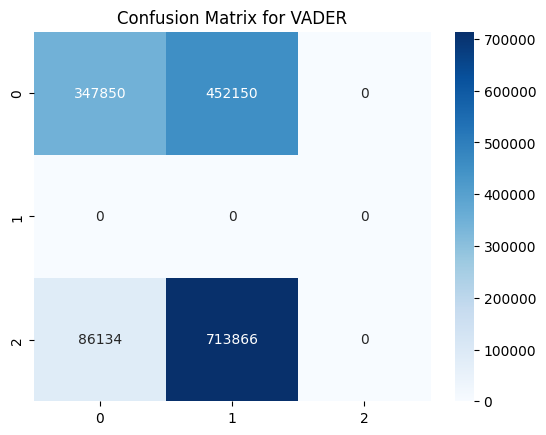

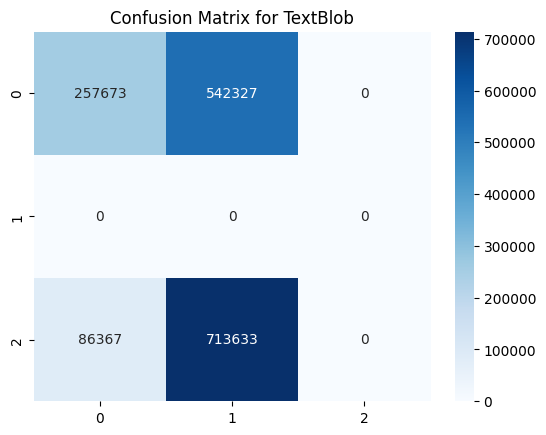

Classification Report for VADER:


c:\Users\dugara\Documents\GitHub-POC\SentimentAnalysis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dugara\Documents\GitHub-POC\SentimentAnalysis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dugara\Documents\GitHub-POC\SentimentAnalysis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

              precision    recall  f1-score   support

           0       0.80      0.43      0.56    800000
           1       0.00      0.00      0.00         0
           4       0.00      0.00      0.00    800000

    accuracy                           0.22   1600000
   macro avg       0.27      0.14      0.19   1600000
weighted avg       0.40      0.22      0.28   1600000

Classification Report for TextBlob:


c:\Users\dugara\Documents\GitHub-POC\SentimentAnalysis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dugara\Documents\GitHub-POC\SentimentAnalysis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dugara\Documents\GitHub-POC\SentimentAnalysis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(aver

              precision    recall  f1-score   support

         0.0       0.75      0.32      0.45    800000
         1.0       0.00      0.00      0.00         0
         4.0       0.00      0.00      0.00    800000

    accuracy                           0.16   1600000
   macro avg       0.25      0.11      0.15   1600000
weighted avg       0.37      0.16      0.23   1600000



c:\Users\dugara\Documents\GitHub-POC\SentimentAnalysis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dugara\Documents\GitHub-POC\SentimentAnalysis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [54]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'target' is the ground truth column
# Evaluate the accuracy of VADER sentiment predictions
accuracy_vader = accuracy_score(df['target'], df['vader_sentiment_label'])
accuracy_textblob = accuracy_score(df['target'], df['textblob_sentiment_label'])

# Print accuracy scores
print(f"Accuracy of VADER: {accuracy_vader}")
print(f"Accuracy of TextBlob: {accuracy_textblob}")

# Confusion matrix for VADER
conf_matrix_vader = confusion_matrix(df['target'], df['vader_sentiment_label'])
sns.heatmap(conf_matrix_vader, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for VADER")
plt.show()

# Confusion matrix for TextBlob
conf_matrix_textblob = confusion_matrix(df['target'], df['textblob_sentiment_label'])
sns.heatmap(conf_matrix_textblob, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for TextBlob")
plt.show()

# Detailed classification report
print("Classification Report for VADER:")
print(classification_report(df['target'], df['vader_sentiment_label']))

print("Classification Report for TextBlob:")
print(classification_report(df['target'], df['textblob_sentiment_label']))


##### Visualize the Sentiment Distribution Vader vs TextBlob

C:\Users\dugara\AppData\Local\Temp\ipykernel_56484\1051295694.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='vader_sentiment_label', data=df, palette='Blues')


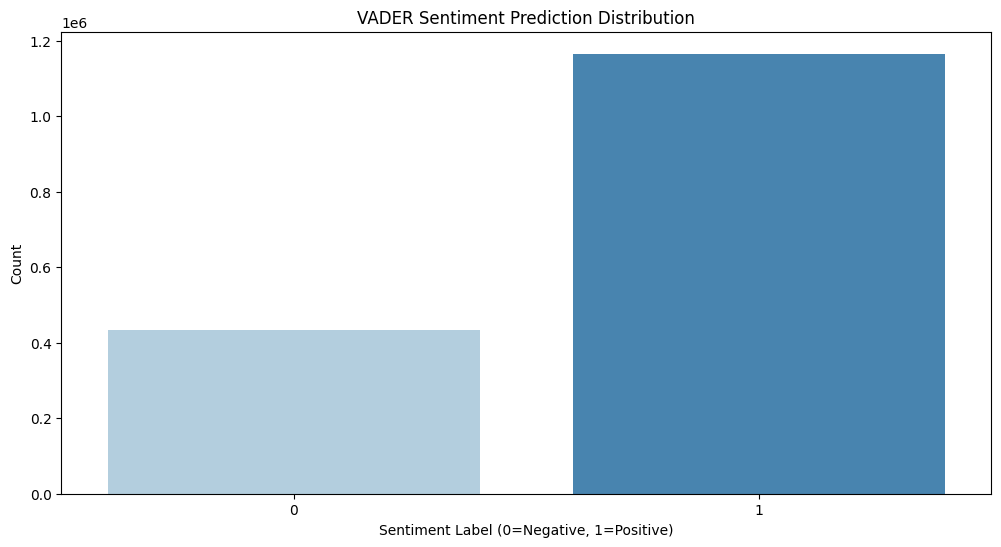

C:\Users\dugara\AppData\Local\Temp\ipykernel_56484\1051295694.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='textblob_sentiment_label', data=df, palette='Blues')


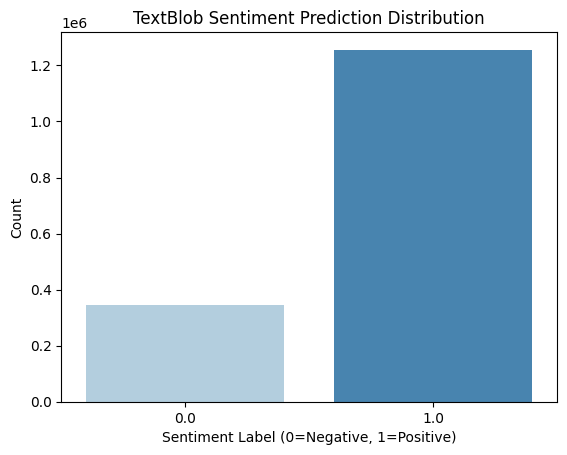

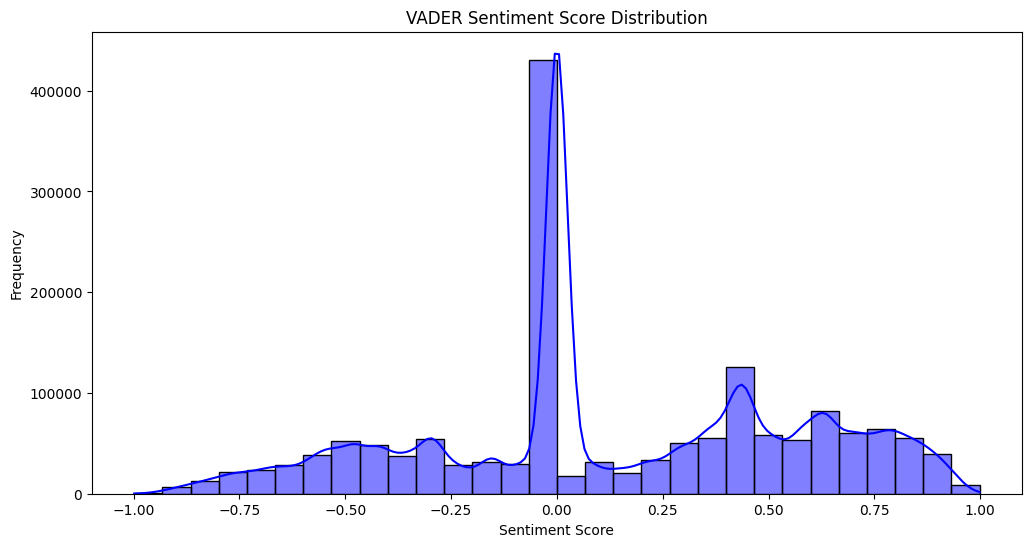

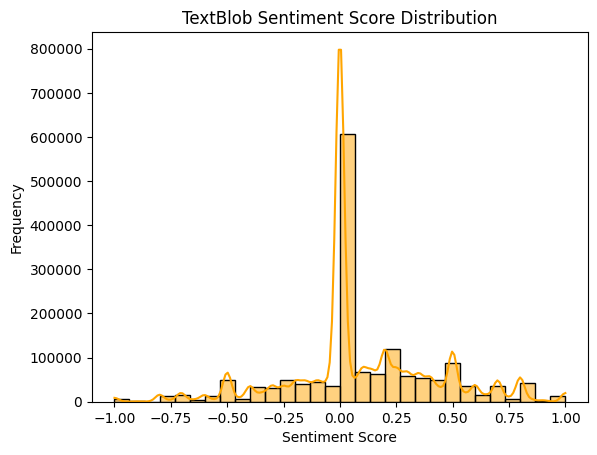

In [55]:
# Visualize the sentiment distribution predicted by VADER and TextBlob
plt.figure(figsize=(12, 6))

# VADER sentiment prediction distribution
sns.countplot(x='vader_sentiment_label', data=df, palette='Blues')
plt.title('VADER Sentiment Prediction Distribution')
plt.xlabel('Sentiment Label (0=Negative, 1=Positive)')
plt.ylabel('Count')
plt.show()

# TextBlob sentiment prediction distribution
sns.countplot(x='textblob_sentiment_label', data=df, palette='Blues')
plt.title('TextBlob Sentiment Prediction Distribution')
plt.xlabel('Sentiment Label (0=Negative, 1=Positive)')
plt.ylabel('Count')
plt.show()

# Visualize sentiment scores for VADER and TextBlob
plt.figure(figsize=(12, 6))

# VADER sentiment score distribution
sns.histplot(df['vader_sentiment'], bins=30, kde=True, color='blue')
plt.title('VADER Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

# TextBlob sentiment score distribution
sns.histplot(df['textblob_sentiment_score'], bins=30, kde=True, color='orange')
plt.title('TextBlob Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()


##### Evaluate the Performance Vader vs Roberta

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Compare VADER and RoBERTa sentiment predictions with the ground truth
accuracy_vader = accuracy_score(df['target'], df['vader_sentiment_label'])
accuracy_roberta = accuracy_score(df['target'], df['roberta_sentiment'])

# Print accuracy scores
print(f"Accuracy of VADER: {accuracy_vader}")
print(f"Accuracy of RoBERTa: {accuracy_roberta}")

# Confusion matrix for VADER
conf_matrix_vader = confusion_matrix(df['target'], df['vader_sentiment_label'])
sns.heatmap(conf_matrix_vader, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for VADER")
plt.show()

# Confusion matrix for RoBERTa
conf_matrix_roberta = confusion_matrix(df['target'], df['roberta_sentiment'])
sns.heatmap(conf_matrix_roberta, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for RoBERTa")
plt.show()

# Detailed classification report for VADER
print("Classification Report for VADER:")
print(classification_report(df['target'], df['vader_sentiment_label']))

# Detailed classification report for RoBERTa
print("Classification Report for RoBERTa:")
print(classification_report(df['target'], df['roberta_sentiment']))


##### Visualize the Sentiment Distribution Vader vs Roberta

In [ ]:
# Visualize the sentiment distribution predicted by VADER and RoBERTa
sns.countplot(x='vader_sentiment_label', data=df, palette='Blues')
plt.title('VADER Sentiment Prediction Distribution')
plt.show()

sns.countplot(x='roberta_sentiment', data=df, palette='Blues')
plt.title('RoBERTa Sentiment Prediction Distribution')
plt.show()
